##***How to compress the FTSE-MIB market using autoencoders***


$\textbf{Objective of the analysis:}$

*   Explore the use of $\textbf{advanced deep learning algorithms}$ for stock-index tracking;

*   Partially replicate the $\textbf{FTSE MIB}$ Index by optimizing the tracking $\textit{portfolio's returns}$ compared to the $\textit{target index}$.

Deep learning algorithm $\Rightarrow$ $\textbf{autoencoder}$ is a data compression algorithm that introduces some loss in the process.

It consists of two main components: an $\textit{Encoder}$ and a $\textit{Decoder}$. The encoder $E$ takes a data point $x$ from the dataset and maps it to a new point $E(x)$ in a lower-dimensional space ($\textit{Latent Space}$).

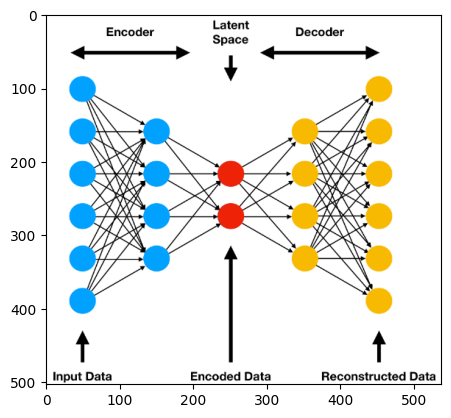

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/autoenc.png'
image = Image.open(image_path)
plt.imshow(image)
plt.show()

The decoder $D$ then takes $E(x)$ and maps it back to a second new point $D(E(x))$ in the original high-dimensional space where $x$ belongs. Typically, both the encoder and decoder are implemented as neural networks, commonly using $\textbf{ReLU}$ activation functions.

The $\textbf{loss function}$ of an autoencoder computes the sum of differences between each data point $x$ in a training dataset and its corresponding reconstruction $D(E(x))$.

If this loss is small when calculated over a validation dataset, it indicates that the decoder $D$ is successful in reconstructing an arbitrary data point $x$ from its compressed representation $E(x)$.

\\

$\textbf{Methodology of the analysis:}$

*   Extract the complex $\textit{non-linear}$ relationship between index constituents (companies);
*   Select a subset of constituents to construct a dynamic $\textit{tracking portfolio}$ using auto-encoders.

\\

$\textbf{Results of the analysis:}$ the $\textit{tracking error}$ is a result of the analysis carried out using an autoencoder.

$\Rightarrow$ It refers to the discrepancy between the companies selected by the algorithm based on the loss function used. Because autoencoders are used to compress data, the choice of companies will also affect error tracking.

$\Rightarrow$ If the number of companies selected by the loss function changes  this will have an impact on the companies being considered in algorithm training. However, it is important to pay attention to $\textbf{overfitting}$, which is the risk that the algorithm will adapt too much to specific training data, losing generality and failing to generalize well on new data.

## Imports

The following code downloads the packages:
*   **yfinance** library, which provides an interface for retrieving financial data from Yahoo Finance.
*   **pandas** library, which offers data structures and functions for data manipulation and analysis.
*   **datetime** and **timedelta** classes from the datetime module. These classes allow for the handling of dates and times.
*   **regularizers** module from **keras**. Regularizers contains functions for applying regularization techniques during neural network training.
*   **numpy** library, which provides data structures and functions for scientific computing.
*   **matplotlib.pyplot** library, which allows for generating plots and visualizing data.
*   **load_workbook** function from the openpyxl module. This function allows for loading an existing Excel workbook so that it can be manipulated or updated.

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from tensorflow import keras
from keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
from openpyxl import load_workbook

## Download data from Yahoo Finance

In the provide code, we are downloading stock price from Yahoo Finance, considering prices at 30' intervals, resulting in a total of 714 prices.
Additionally, we are performing the same procedure for the components of the FTSE MIB

In [ ]:
# Lista delle componenti del FTSE MIB
ftse_mib_components = ['A2A.MI', 'AMP.MI', 'AZM.MI', 'BGN.MI', 'BMED.MI', 'BMPS.MI', 'BAMI.MI', 'BPE.MI', 'CPR.MI', 'CNHI.MI', 'DIA.MI', 'ENEL.MI', 'ENI.MI', 'ERG.MI', 'RACE.MI', 'FBK.MI', 'G.MI', 'HER.MI', 'IP.MI', 'ISP.MI', 'INW.MI', 'IG.MI', 'IVG.MI', 'LDO.MI', 'MB.MI', 'MONC.MI', 'NEXI.MI', 'PIRC.MI', 'PST.MI', 'PRY.MI', 'REC.MI', 'SPM.MI', 'SRG.MI', 'STLAM.MI', 'STMMI.MI', 'TIT.MI', 'TEN.MI', 'TRN.MI', 'UCG.MI', 'UNI.MI']

# Imposta le date di inizio e fine
end_date = datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.now() - timedelta(days=59)).strftime("%Y-%m-%d")

# Crea un DataFrame vuoto per i dati
data = pd.DataFrame()

# Scarica i dati per ogni componente del FTSE MIB
for symbol in ftse_mib_components:
    try:
        # Scarica i dati utilizzando yfinance
        stock_data = yf.download(symbol, start=start_date, end=end_date, interval='30m')

        # Seleziona solo la colonna "Adj Close"
        stock_data = stock_data[['Adj Close']]

        # Rinomina la colonna "Adj Close" con il simbolo del titolo per riferimento
        stock_data.rename(columns={'Adj Close': symbol}, inplace=True)

        # Concatena i dati nel DataFrame principale
        data = pd.concat([data, stock_data], axis=1)
    except Exception as e:
        print(f"Errore durante il download dei dati per {symbol}: {e}")

# Salva i dati in un file CSV
#data.to_csv('ftse_mib_data.csv')

# Scarica i dati per l'indice FTSE MIB
try:
    # Scarica i dati utilizzando yfinance
    FTSE_index_data = yf.download('FTSEMIB.MI', start=start_date, end=end_date, interval='30m')

    # Seleziona solo la colonna "Adj Close"
    FTSE_index_data = FTSE_index_data[['Adj Close']]

    # Rinomina la colonna "Adj Close" con 'FTSE MIB' per riferimento
    FTSE_index_data.rename(columns={'Adj Close': 'FTSE MIB'}, inplace=True)

    # Salva i dati in un file CSV
    FTSE_index_data.to_csv('ftse_mib_index_data.csv')

except Exception as e:
    print(f"Errore durante il download dei dati per l'indice FTSE MIB: {e}")


## Computed normalized returns

In this part of the code, logarithmic returns are calculated and subsequently normalized for both the selected tickers and the reference index FTSE MIB.
The formula for the normalized returns is the following:
$(x-μ)/σ$
where $x$ are the log-return of the index, $μ$ the mean and $σ$ the standard deviation.

In [3]:
# Calcola i rendimenti logaritmici
log_returns = np.log(data / data.shift(1))
log_returns_index = np.log(FTSE_index_data / FTSE_index_data.shift(1))

# Normalizza i rendimenti
normalized_returns = (log_returns - log_returns.mean()) / log_returns.std()
normalized_returns_index = (log_returns_index - log_returns_index.mean()) / log_returns_index.std()

# Rimuovi le righe con valori NaN (che si verificano per la prima riga di log_returns)
normalized_returns = normalized_returns.dropna()
normalized_returns_index = normalized_returns_index.dropna()

# Salva i rendimenti normalizzati in un file CSV
#normalized_returns.to_csv('ftse_mib_normalized_returns.csv')
#normalized_returns_index.to_csv('ftse_mib_normalized_returns_index.csv')


## Split the data - Moving windows

Is this section the code creates the Excel files to prepare the data to make the *training*, the *validation* and the *test*.

Setting the number of observation for each set equal to 17 observation per day, 20 days for training (a month, 20 working days), 5 for validation (one week) and 1 for the test (one day) are considered. 17 observations are considered seen that the stock market opens at 9 a.m. and closes at 17 p.m.

After that calculates the number of loops to execute and finally create ther moving windows for each set.

This approach is made with the data of the **tickers** and, in the next section, with the **FTSE MIB**.

In [4]:
# Imposta il numero di osservazioni per giorno e il numero di giorni per ogni set
obs_per_day = 17
days_train = 20
days_val = 5
days_test = 1

# Calcola il numero di righe per ogni set
rows_train = days_train * obs_per_day
rows_val = days_val * obs_per_day
rows_test = days_test * obs_per_day

# Imposta i nomi dei file
file_train = 'X_train.xlsx'
file_val = 'X_val.xlsx'
file_test = 'X_test.xlsx'

# Crea i file Excel vuoti
pd.DataFrame().to_excel(file_train)
pd.DataFrame().to_excel(file_val)
pd.DataFrame().to_excel(file_test)

# Calcola il numero di loop da eseguire (meno i giorni per ogni set per evitare di superare la fine del DataFrame)
num_loops = len(normalized_returns) // obs_per_day - (days_train + days_val + days_test)

for i in range(num_loops):
    # Crea le finestre
    X_train = normalized_returns.iloc[i * obs_per_day:(i + days_train) * obs_per_day]
    X_val = normalized_returns.iloc[(i + days_train) * obs_per_day:(i + days_train + days_val) * obs_per_day]
    X_test = normalized_returns.iloc[(i + days_train + days_val) * obs_per_day:(i + days_train + days_val + days_test) * obs_per_day]

    # Scrive i dati sul file Excel
    with pd.ExcelWriter(file_train, engine='openpyxl', mode='a') as writer:
        X_train.to_excel(writer, sheet_name=f'loop_{i}', index=False)

    with pd.ExcelWriter(file_val, engine='openpyxl', mode='a') as writer:
        X_val.to_excel(writer, sheet_name=f'loop_{i}', index=False)

    with pd.ExcelWriter(file_test, engine='openpyxl', mode='a') as writer:
        X_test.to_excel(writer, sheet_name=f'loop_{i}', index=False)



## Split FTSE data - Moving windows

In [5]:
# Imposta i nomi dei file
file_train = 'X_train_FTSE.xlsx'
file_val = 'X_val_FTSE.xlsx'
file_test = 'X_test_FTSE.xlsx'

# Crea i file Excel vuoti
pd.DataFrame().to_excel(file_train)
pd.DataFrame().to_excel(file_val)
pd.DataFrame().to_excel(file_test)

# Calcola il numero di loop da eseguire (meno i giorni per ogni set per evitare di superare la fine del DataFrame)
num_loops = len(normalized_returns_index) // obs_per_day - (days_train + days_val + days_test)

for i in range(num_loops):
    # Crea le finestre
    X_train_FTSE = normalized_returns_index.iloc[i * obs_per_day:(i + days_train) * obs_per_day]
    X_val_FTSE = normalized_returns_index.iloc[(i + days_train) * obs_per_day:(i + days_train + days_val) * obs_per_day]
    X_test_FTSE = normalized_returns_index.iloc[(i + days_train + days_val) * obs_per_day:(i + days_train + days_val + days_test) * obs_per_day]

    # Scrive i dati sul file Excel
    with pd.ExcelWriter(file_train, engine='openpyxl', mode='a') as writer:
        X_train_FTSE.to_excel(writer, sheet_name=f'loop_{i}', index=False)

    with pd.ExcelWriter(file_val, engine='openpyxl', mode='a') as writer:
        X_val_FTSE.to_excel(writer, sheet_name=f'loop_{i}', index=False)

    with pd.ExcelWriter(file_test, engine='openpyxl', mode='a') as writer:
        X_test_FTSE.to_excel(writer, sheet_name=f'loop_{i}', index=False)

## Autoencoder
*Weight tying* in autoencoder models refers to the practice of forcing the decoder weights to be equal (usually transposed) to those of the encoder. This is done to reduce the total number of parameters that the model needs to learn, helping to prevent overfitting and improving computational efficiency.

In the code, a UnitNorm constraint on the decoder layer weights is used. This constraint normalizes the weights in such a way that their norm (length) along a specified axis is 1. In this case, the axis is set to 0, which means that normalization is applied for each column of the weight matrix.

However, this normalization does not in itself guarantee that the decoder weights are a transpose of the encoder weights, which is what we usually mean when we talk about *Weight tying*. The UnitNorm normalization simply ensures that the standard of weights is 1, but does not impose any restrictions on the structure or relationships between the weights in the decoder and those in the encoder.

This section of the code contains the function that generates the autoencoders.

It's important to note that the autoencoder learns up to 250 neurons: beyond that point, it learns less. It is possible to increase the number of neurons until the autoencoder continues to learn.

In [6]:
class Autoencoder:
    def __init__(self, len_data, learning_rate):
        # Define the encoder
        encoder_layer = keras.layers.Dense(40, activation="selu",
                                           activity_regularizer=regularizers.l1(10e-5), use_bias=True)
        self._encoder = keras.models.Sequential([
            keras.layers.InputLayer((len_data,)),
            encoder_layer,
        ])

        # Define the decoder
        self._decoder = keras.models.Sequential([
            keras.layers.Dense(len_data, activation="selu", use_bias=False,
                               kernel_constraint=keras.constraints.UnitNorm(axis=0)),
            keras.layers.Reshape([len_data, 1])
        ])

        # Combine the encoder and decoder to create the autoencoder
        self._autoencoder = keras.models.Sequential([self._encoder, self._decoder])

        # Compile the model
        self._autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate), loss="mse")

    def fit(self, X_train, X_val, epochs):
        history = self._autoencoder.fit(X_train, X_train,
                                        epochs=epochs,
                                        validation_data=(X_val, X_val))
        return history


In [7]:
autoencoder = Autoencoder(len_data=40, learning_rate=0.001)
history = autoencoder.fit(X_train, X_val, epochs=250)

Epoch 1/250
11/11 [==============================] - 4s 135ms/step - loss: 1.6230 - val_loss: 1.3907
Epoch 2/250
11/11 [==============================] - 0s 7ms/step - loss: 1.3591 - val_loss: 1.2389
Epoch 3/250
11/11 [==============================] - 0s 7ms/step - loss: 1.1608 - val_loss: 1.1304
Epoch 4/250
11/11 [==============================] - 0s 6ms/step - loss: 1.0236 - val_loss: 1.0429
Epoch 5/250
11/11 [==============================] - 0s 6ms/step - loss: 0.9240 - val_loss: 0.9715
Epoch 6/250
11/11 [==============================] - 0s 6ms/step - loss: 0.8443 - val_loss: 0.9098
Epoch 7/250
11/11 [==============================] - 0s 5ms/step - loss: 0.7762 - val_loss: 0.8559
Epoch 8/250
11/11 [==============================] - 0s 7ms/step - loss: 0.7242 - val_loss: 0.8090
Epoch 9/250
11/11 [==============================] - 0s 6ms/step - loss: 0.6806 - val_loss: 0.7647
Epoch 10/250
11/11 [==============================] - 0s 6ms/step - loss: 0.6424 - val_loss: 0.7250
Epoch 1

In [8]:
# Assume X is your data and autoencoder is an instance of the Autoencoder class
X_reconstructed = autoencoder._autoencoder.predict(X_train)
X_reconstructed = X_reconstructed[:,:,0]


11/11 [==============================] - 0s 2ms/step


In [9]:
def loss_function(X_train, X_reconstructed):
    # Calcola la norma L2 (o distanza euclidee) tra i vettori originali e ricostruiti
    l2_norm = np.linalg.norm(X_train - X_reconstructed, ord = 2, axis=0)

    return l2_norm
l2_norm = loss_function(X_train, X_reconstructed)

In [10]:
# Ordina in modo crescente le componenti del vettore
indici_ordinati = np.argsort(l2_norm)

# Seleziona gli indici fino al valore massimo
indici_selezionati = indici_ordinati[:32]

ftse_selected = [ftse_mib_components[i] for i in indici_selezionati]

print(ftse_selected)

['TIT.MI', 'BMED.MI', 'MB.MI', 'HER.MI', 'AMP.MI', 'MONC.MI', 'REC.MI', 'BMPS.MI', 'TEN.MI', 'PST.MI', 'UCG.MI', 'SPM.MI', 'STMMI.MI', 'BPE.MI', 'ENI.MI', 'SRG.MI', 'CPR.MI', 'BAMI.MI', 'ISP.MI', 'TRN.MI', 'PRY.MI', 'NEXI.MI', 'IVG.MI', 'RACE.MI', 'CNHI.MI', 'FBK.MI', 'ENEL.MI', 'IP.MI', 'ERG.MI', 'PIRC.MI', 'STLAM.MI', 'DIA.MI']


In [11]:
# Selezione delle colonne desiderate utilizzando il metodo loc
X_train_selected = X_train.loc[:, ftse_selected]


In [12]:
X_train_FTSE = X_train_FTSE.values
X_train_selected = X_train_selected.values

# Risolvi il problema dei minimi quadrati per trovare w
w_train, residuals, rank, singular_values= np.linalg.lstsq(X_train_selected, X_train_FTSE, rcond=None) #provare con non normalizzati
w_train = w_train/np.sum(w_train)

In [13]:
rendimenti_ricostruiti = np.dot(X_train_selected,w_train)

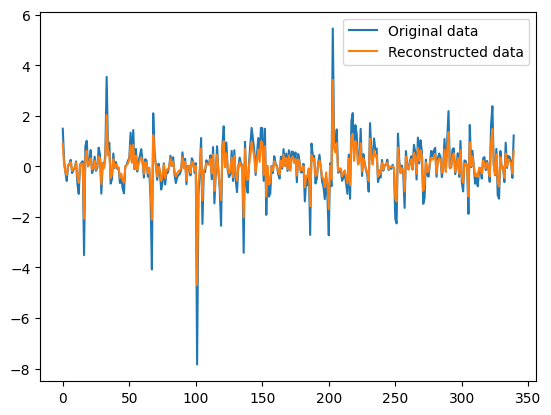

In [14]:
# Assume X and X_reconstructed are 1D arrays. If they are not, you may need to reshape them.
plt.plot(X_train_FTSE, label='Original data')
plt.plot(rendimenti_ricostruiti, label='Reconstructed data')
plt.legend()
plt.show()

## Performance - Test

The code uses an autoencoder to approximate the returns of the selected data and shows a comparison between the original data and those reconstructed using a graph.

At the test level, the following has been done: the matrix of test returns is multiplied by the weights found during the training. The goal is to try to reconstruct the data for the next analysis.

In [15]:
# Selezione delle colonne desiderate utilizzando il metodo loc
X_test_selected = X_test.loc[:, ftse_selected]


In [18]:
X_test_FTSE = X_test_FTSE.values
X_test_selected = X_test_selected.values

rendimenti_ricostruiti_test = np.dot(X_test_selected,w_train)

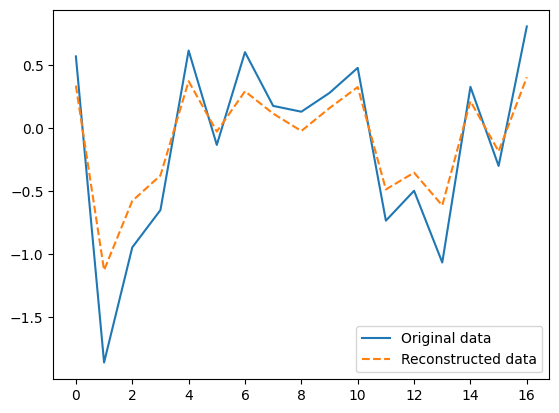

In [19]:
# Assume X and X_reconstructed are 1D arrays. If they are not, you may need to reshape them.
plt.plot(X_test_FTSE, label='Original data')
plt.plot(rendimenti_ricostruiti_test, label='Reconstructed data', linestyle = 'dashed')
plt.legend()
plt.show()

The graph illustrates the reconstruction of the index (orange) in comparison to the original index (blue). They exhibit a similar trend, but there is a loss of information due to the fact that the reconstructed index tracks a smaller number of stocks.

## For loop trough windows (32 assets)


This code is created considering a rolling window, namely moving by a day.



In [20]:
result_f = []
benchmark_f = []

for j in range(1, num_loops):

  X_train_f = pd.read_excel("X_train.xlsx", sheet_name= j)
  X_val_f = pd.read_excel("X_val.xlsx", sheet_name= j)
  X_test_f = pd.read_excel("X_test.xlsx", sheet_name= j)
  X_train_FTSE_f = pd.read_excel("X_train_FTSE.xlsx", sheet_name= j)
  X_val_FTSE_f = pd.read_excel("X_val_FTSE.xlsx", sheet_name= j)
  X_test_FTSE_f = pd.read_excel("X_test_FTSE.xlsx", sheet_name= j)

  history_f = autoencoder.fit(X_train_f, X_val_f, epochs=180)

  # Assume X is your data and autoencoder is an instance of the Autoencoder class
  X_reconstructed_f = autoencoder._autoencoder.predict(X_train_f)
  X_reconstructed_f = X_reconstructed_f[:,:,0]
  l2_norm_f = loss_function(X_train_f, X_reconstructed_f)

  # Ordina in modo crescente le componenti del vettore
  indici_ordinati_f = np.argsort(l2_norm_f)

  # Seleziona gli indici fino al valore massimo
  indici_selezionati_f = indici_ordinati_f[:32]

  ftse_selected_f = [ftse_mib_components[i] for i in indici_selezionati_f]

  # Selezione delle colonne desiderate utilizzando il metodo loc
  X_train_selected_f = X_train_f.loc[:, ftse_selected_f]

  X_train_FTSE_f = X_train_FTSE_f.values
  X_train_selected_f = X_train_selected_f.values

  # Risolvi il problema dei minimi quadrati per trovare w
  w_train_f, residuals_f, rank_f, singular_values_f = np.linalg.lstsq(X_train_selected_f, X_train_FTSE_f, rcond=None)
  w_train_f = w_train_f/np.sum(w_train_f)

  # Selezione delle colonne desiderate utilizzando il metodo loc
  X_test_selected_f = X_test_f.loc[:, ftse_selected_f]

  rendimenti_ricostruiti_test_f =  np.dot(X_test_selected_f,w_train_f)
  result_f = np.append(result_f, rendimenti_ricostruiti_test_f)
  benchmark_f = np.append(benchmark_f, X_test_FTSE_f)


Output streaming troncato alle ultime 5000 righe.
11/11 [==============================] - 0s 8ms/step - loss: 0.2325 - val_loss: 0.0618
Epoch 29/180
11/11 [==============================] - 0s 7ms/step - loss: 0.2322 - val_loss: 0.0616
Epoch 30/180
11/11 [==============================] - 0s 6ms/step - loss: 0.2319 - val_loss: 0.0617
Epoch 31/180
11/11 [==============================] - 0s 5ms/step - loss: 0.2317 - val_loss: 0.0615
Epoch 32/180
11/11 [==============================] - 0s 5ms/step - loss: 0.2316 - val_loss: 0.0617
Epoch 33/180
11/11 [==============================] - 0s 5ms/step - loss: 0.2314 - val_loss: 0.0616
Epoch 34/180
11/11 [==============================] - 0s 7ms/step - loss: 0.2311 - val_loss: 0.0614
Epoch 35/180
11/11 [==============================] - 0s 5ms/step - loss: 0.2310 - val_loss: 0.0613
Epoch 36/180
11/11 [==============================] - 0s 5ms/step - loss: 0.2309 - val_loss: 0.0613
Epoch 37/180
11/11 [==============================] - 0s 5ms/st

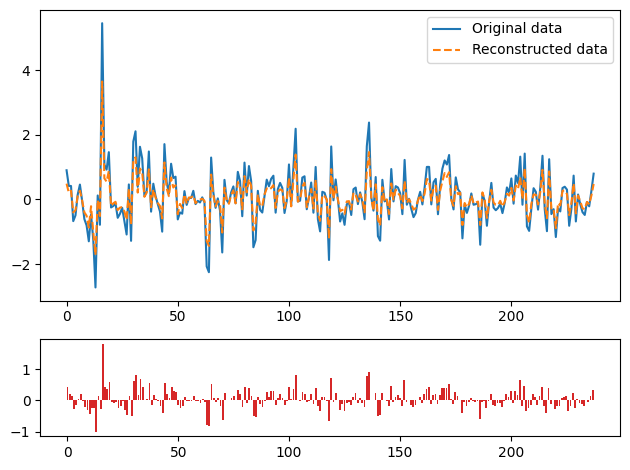

In [21]:
# Crea una griglia di subplot con altezze specificate
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

# Traccia i dati originali e ricostruiti sul primo asse
ax1.plot(benchmark_f, label='Original data')
ax1.plot(result_f, label='Reconstructed data', linestyle = 'dashed')
ax1.legend()

# Calcola le differenze e traccia come un grafico a barre sul secondo asse
difference = benchmark_f - result_f
ax2.bar(range(len(difference)), difference, color='tab:red')

# Mostra i grafici
plt.tight_layout()
plt.show()

In the graph, the orange line represents the reconstructed data, while the blue line represents the original data.

The red plot represents the difference between the orange and blue lines, indicating the error or discrepancy between the reconstructed and original data. This error signifies the deviations or inaccuracies encountered during the testing phase.

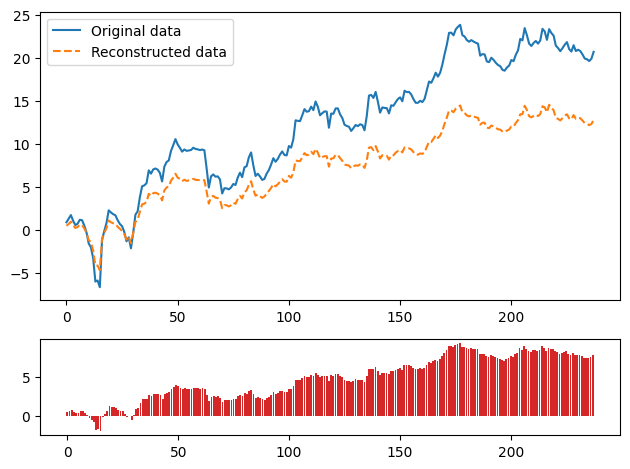

In [22]:
# Crea una griglia di subplot con altezze specificate
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

# Traccia i dati originali e ricostruiti sul primo asse
ax1.plot(np.cumsum(benchmark_f), label='Original data')
ax1.plot(np.cumsum(result_f), label='Reconstructed data', linestyle = 'dashed')
ax1.legend()

# Calcola le differenze e traccia come un grafico a barre sul secondo asse
difference = np.cumsum(benchmark_f) - np.cumsum(result_f)
ax2.bar(range(len(difference)), difference, color='tab:red')

# Mostra i grafici
plt.tight_layout()
plt.show()


When cumulating the data, it is observed that the error tends to increase over time. The cumulative error gradually grows because it accumulates over the entire period.

In the initial period, the error may be relatively lower compared to later periods.

## For loop trough windows 8 best 2 worst
This part of the code take into account a porftolio composed by 10 companies of the 40 of FTSE MIB: in particular the first 8 and the last 2 (80% and 20%). The reason behind this choice is because the firsts have high correlation, instead the last 2 are uncorrelated.
The companies are ordinated by the autoencoders from the best to the worst one.


In [ ]:
result_10 = []
benchmark_10 = []

for j in range(1, num_loops):

  X_train_10 = pd.read_excel("X_train.xlsx", sheet_name= j)
  X_val_10 = pd.read_excel("X_val.xlsx", sheet_name= j)
  X_test_10 = pd.read_excel("X_test.xlsx", sheet_name= j)
  X_train_FTSE_10 = pd.read_excel("X_train_FTSE.xlsx", sheet_name= j)
  X_val_FTSE_10 = pd.read_excel("X_val_FTSE.xlsx", sheet_name= j)
  X_test_FTSE_10 = pd.read_excel("X_test_FTSE.xlsx", sheet_name= j)

  history_10 = autoencoder.fit(X_train_10, X_val_10, epochs=50)

  # Assume X is your data and autoencoder is an instance of the Autoencoder class
  X_reconstructed_10 = autoencoder._autoencoder.predict(X_train_10)
  X_reconstructed_10 = X_reconstructed_10[:,:,0]
  l2_norm_10 = loss_function(X_train_10, X_reconstructed_10)

  # Ordina in modo crescente le componenti del vettore
  indici_ordinati_10 = np.argsort(l2_norm_10)

  # Seleziona gli indici fino al valore massimo
  indici_selezionati_10 = np.concatenate((indici_ordinati_10[:8], indici_ordinati_10[-2:]))

  ftse_selected_10 = [ftse_mib_components[i] for i in indici_selezionati_10]

  # Selezione delle colonne desiderate utilizzando il metodo loc
  X_train_selected_10 = X_train_10.loc[:, ftse_selected_10]

  X_train_FTSE_10 = X_train_FTSE_10.values
  X_train_selected_10 = X_train_selected_10.values

  # Risolvi il problema dei minimi quadrati per trovare w
  w_train_10, residuals_10, rank_10, singular_values_10 = np.linalg.lstsq(X_train_selected_10, X_train_FTSE_10, rcond=None)
  w_train_10 = w_train_10/np.sum(w_train_10)

  # Selezione delle colonne desiderate utilizzando il metodo loc
  X_test_selected_10 = X_test_10.loc[:, ftse_selected_10]

  rendimenti_ricostruiti_test_10 =  np.dot(X_test_selected_10,w_train_10)
  result_10 = np.append(result_10, rendimenti_ricostruiti_test_10)
  benchmark_10 = np.append(benchmark_10, X_test_FTSE_10)

Epoch 1/50
11/11 [==============================] - 0s 14ms/step - loss: 0.2230 - val_loss: 0.0574
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 0.2229 - val_loss: 0.0573
Epoch 3/50
11/11 [==============================] - 0s 7ms/step - loss: 0.2228 - val_loss: 0.0573
Epoch 4/50
11/11 [==============================] - 0s 6ms/step - loss: 0.2230 - val_loss: 0.0575
Epoch 5/50
11/11 [==============================] - 0s 9ms/step - loss: 0.2229 - val_loss: 0.0576
Epoch 6/50
11/11 [==============================] - 0s 6ms/step - loss: 0.2230 - val_loss: 0.0576
Epoch 7/50
11/11 [==============================] - 0s 7ms/step - loss: 0.2230 - val_loss: 0.0582
Epoch 8/50
11/11 [==============================] - 0s 5ms/step - loss: 0.2233 - val_loss: 0.0577
Epoch 9/50
11/11 [==============================] - 0s 6ms/step - loss: 0.2233 - val_loss: 0.0575
Epoch 10/50
11/11 [==============================] - 0s 5ms/step - loss: 0.2235 - val_loss: 0.0579
Epoch 11/50
11/11 

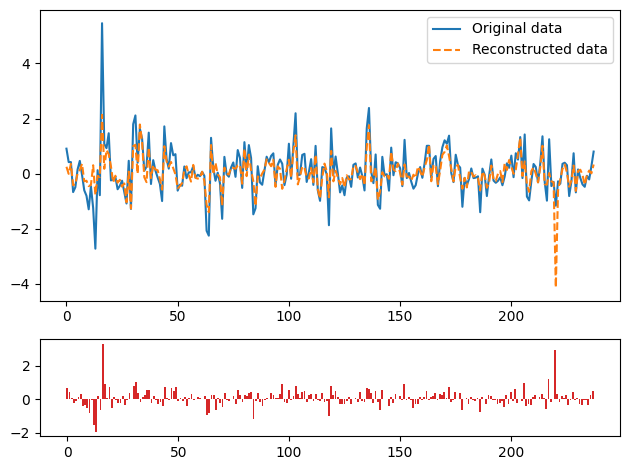

In [ ]:
# Crea una griglia di subplot con altezze specificate
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

# Traccia i dati originali e ricostruiti sul primo asse
ax1.plot(benchmark_10, label='Original data')
ax1.plot(result_10, label='Reconstructed data', linestyle = 'dashed')
ax1.legend()

# Calcola le differenze e traccia come un grafico a barre sul secondo asse
difference = benchmark_10 - result_10
ax2.bar(range(len(difference)), difference, color='tab:red')

# Mostra i grafici
plt.tight_layout()
plt.show()

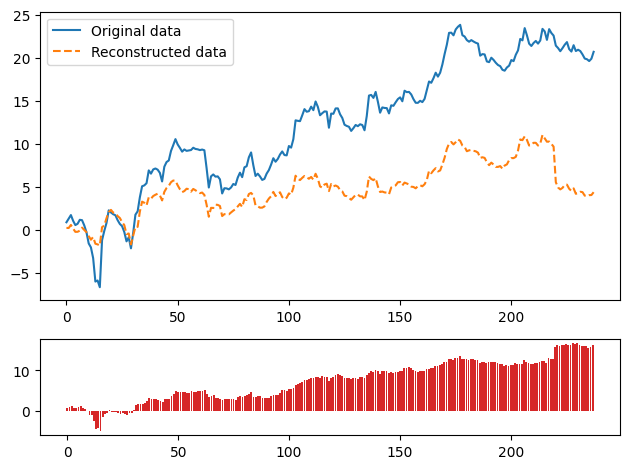

In [ ]:
# Crea una griglia di subplot con altezze specificate
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

# Traccia i dati originali e ricostruiti sul primo asse
ax1.plot(np.cumsum(benchmark_10), label='Original data')
ax1.plot(np.cumsum(result_10), label='Reconstructed data', linestyle = 'dashed')
ax1.legend()

# Calcola le differenze e traccia come un grafico a barre sul secondo asse
difference = np.cumsum(benchmark_10) - np.cumsum(result_10)
ax2.bar(range(len(difference)), difference, color='tab:red')

# Mostra i grafici
plt.tight_layout()
plt.show()

As in the previous case, it is observed that the error tends to increase over time. The cumulative error gradually grows because it accumulates over the entire period.
In the initial period, the error may be relatively lower compared to later periods.

## For loop trough windows 16 best 4 worst
This part of the code is the same as before but 20 companies are selected (80% and 20% of 20).

In [ ]:
result_20 = []
benchmark_20 = []

for j in range(1, num_loops):

  X_train_20 = pd.read_excel("X_train.xlsx", sheet_name= j)
  X_val_20 = pd.read_excel("X_val.xlsx", sheet_name= j)
  X_test_20 = pd.read_excel("X_test.xlsx", sheet_name= j)
  X_train_FTSE_20 = pd.read_excel("X_train_FTSE.xlsx", sheet_name= j)
  X_val_FTSE_20 = pd.read_excel("X_val_FTSE.xlsx", sheet_name= j)
  X_test_FTSE_20 = pd.read_excel("X_test_FTSE.xlsx", sheet_name= j)

  history_20 = autoencoder.fit(X_train_20, X_val_20, epochs=50)

  # Assume X is your data and autoencoder is an instance of the Autoencoder class
  X_reconstructed_20 = autoencoder._autoencoder.predict(X_train_20)
  X_reconstructed_20 = X_reconstructed_20[:,:,0]
  l2_norm_20 = loss_function(X_train_20, X_reconstructed_20)

  # Ordina in modo crescente le componenti del vettore
  indici_ordinati_20 = np.argsort(l2_norm_20)

  # Seleziona gli indici fino al valore massimo
  indici_selezionati_20 = np.concatenate((indici_ordinati_20[:16], indici_ordinati_20[-4:]))

  ftse_selected_20 = [ftse_mib_components[i] for i in indici_selezionati_20]

  # Selezione delle colonne desiderate utilizzando il metodo loc
  X_train_selected_20 = X_train_20.loc[:, ftse_selected_20]

  X_train_FTSE_20 = X_train_FTSE_20.values
  X_train_selected_20 = X_train_selected_20.values

  # Risolvi il problema dei minimi quadrati per trovare w
  w_train_20, residuals_20, rank_20, singular_values_20 = np.linalg.lstsq(X_train_selected_20, X_train_FTSE_20, rcond=None)
  w_train_20 = w_train_20/np.sum(w_train_20)

  # Selezione delle colonne desiderate utilizzando il metodo loc
  X_test_selected_20 = X_test_20.loc[:, ftse_selected_20]

  rendimenti_ricostruiti_test_20 =  np.dot(X_test_selected_20,w_train_20)
  result_20 = np.append(result_20, rendimenti_ricostruiti_test_20)
  benchmark_20 = np.append(benchmark_20, X_test_FTSE_20)

Epoch 1/50
11/11 [==============================] - 0s 13ms/step - loss: 0.2268 - val_loss: 0.0545
Epoch 2/50
11/11 [==============================] - 0s 6ms/step - loss: 0.2253 - val_loss: 0.0555
Epoch 3/50
11/11 [==============================] - 0s 6ms/step - loss: 0.2246 - val_loss: 0.0558
Epoch 4/50
11/11 [==============================] - 0s 7ms/step - loss: 0.2245 - val_loss: 0.0561
Epoch 5/50
11/11 [==============================] - 0s 6ms/step - loss: 0.2242 - val_loss: 0.0560
Epoch 6/50
11/11 [==============================] - 0s 7ms/step - loss: 0.2240 - val_loss: 0.0562
Epoch 7/50
11/11 [==============================] - 0s 7ms/step - loss: 0.2239 - val_loss: 0.0563
Epoch 8/50
11/11 [==============================] - 0s 7ms/step - loss: 0.2242 - val_loss: 0.0567
Epoch 9/50
11/11 [==============================] - 0s 5ms/step - loss: 0.2239 - val_loss: 0.0563
Epoch 10/50
11/11 [==============================] - 0s 6ms/step - loss: 0.2236 - val_loss: 0.0565
Epoch 11/50
11/11 

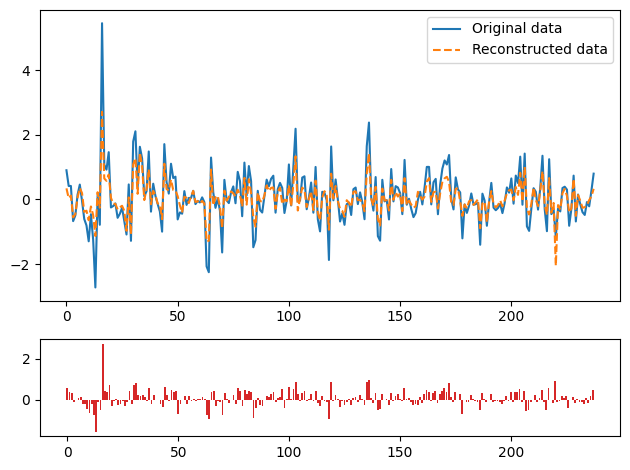

In [ ]:
# Crea una griglia di subplot con altezze specificate
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

# Traccia i dati originali e ricostruiti sul primo asse
ax1.plot(benchmark_20, label='Original data')
ax1.plot(result_20, label='Reconstructed data', linestyle = 'dashed')
ax1.legend()

# Calcola le differenze e traccia come un grafico a barre sul secondo asse
difference = benchmark_20 - result_20
ax2.bar(range(len(difference)), difference, color='tab:red')

# Mostra i grafici
plt.tight_layout()
plt.show()

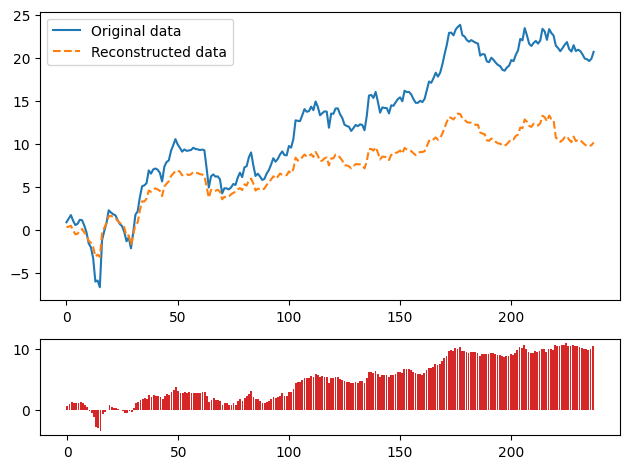

In [ ]:
# Crea una griglia di subplot con altezze specificate
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

# Traccia i dati originali e ricostruiti sul primo asse
ax1.plot(np.cumsum(benchmark_20), label='Original data')
ax1.plot(np.cumsum(result_20), label='Reconstructed data', linestyle = 'dashed')
ax1.legend()

# Calcola le differenze e traccia come un grafico a barre sul secondo asse
difference = np.cumsum(benchmark_20) - np.cumsum(result_20)
ax2.bar(range(len(difference)), difference, color='tab:red')

# Mostra i grafici
plt.tight_layout()
plt.show()

The reason of the resulta in the graphs above are the same of the 10 companies' case.

## For loop trough windows 24 best 6 worst
The last part is about the same procedure for the two before but choosing 30 companies.

In [ ]:
result_30 = []
benchmark_30 = []

for j in range(1, num_loops):

  X_train_30 = pd.read_excel("X_train.xlsx", sheet_name= j)
  X_val_30 = pd.read_excel("X_val.xlsx", sheet_name= j)
  X_test_30 = pd.read_excel("X_test.xlsx", sheet_name= j)
  X_train_FTSE_30 = pd.read_excel("X_train_FTSE.xlsx", sheet_name= j)
  X_val_FTSE_30 = pd.read_excel("X_val_FTSE.xlsx", sheet_name= j)
  X_test_FTSE_30 = pd.read_excel("X_test_FTSE.xlsx", sheet_name= j)

  history_30 = autoencoder.fit(X_train_30, X_val_30, epochs=50)

  # Assume X is your data and autoencoder is an instance of the Autoencoder class
  X_reconstructed_30 = autoencoder._autoencoder.predict(X_train_30)
  X_reconstructed_30 = X_reconstructed_30[:,:,0]
  l2_norm_30 = loss_function(X_train_30, X_reconstructed_30)

  # Ordina in modo crescente le componenti del vettore
  indici_ordinati_30 = np.argsort(l2_norm_30)

  # Seleziona gli indici fino al valore massimo
  indici_selezionati_30 = np.concatenate((indici_ordinati_20[:24], indici_ordinati_20[-6:]))

  ftse_selected_30 = [ftse_mib_components[i] for i in indici_selezionati_30]

  # Selezione delle colonne desiderate utilizzando il metodo loc
  X_train_selected_30 = X_train_30.loc[:, ftse_selected_30]

  X_train_FTSE_30 = X_train_FTSE_30.values
  X_train_selected_30 = X_train_selected_30.values

  # Risolvi il problema dei minimi quadrati per trovare w
  w_train_30, residuals_30, rank_30, singular_values_30 = np.linalg.lstsq(X_train_selected_30, X_train_FTSE_30, rcond=None)
  w_train_30 = w_train_30/np.sum(w_train_30)

  # Selezione delle colonne desiderate utilizzando il metodo loc
  X_test_selected_30 = X_test_30.loc[:, ftse_selected_30]

  rendimenti_ricostruiti_test_30 =  np.dot(X_test_selected_30,w_train_30)
  result_30 = np.append(result_30, rendimenti_ricostruiti_test_30)
  benchmark_30 = np.append(benchmark_30, X_test_FTSE_30)

Epoch 1/50
11/11 [==============================] - 0s 9ms/step - loss: 0.2271 - val_loss: 0.0544
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 0.2255 - val_loss: 0.0556
Epoch 3/50
11/11 [==============================] - 0s 5ms/step - loss: 0.2250 - val_loss: 0.0562
Epoch 4/50
11/11 [==============================] - 0s 5ms/step - loss: 0.2251 - val_loss: 0.0565
Epoch 5/50
11/11 [==============================] - 0s 4ms/step - loss: 0.2246 - val_loss: 0.0561
Epoch 6/50
11/11 [==============================] - 0s 6ms/step - loss: 0.2241 - val_loss: 0.0560
Epoch 7/50
11/11 [==============================] - 0s 5ms/step - loss: 0.2239 - val_loss: 0.0560
Epoch 8/50
11/11 [==============================] - 0s 7ms/step - loss: 0.2239 - val_loss: 0.0572
Epoch 9/50
11/11 [==============================] - 0s 7ms/step - loss: 0.2239 - val_loss: 0.0569
Epoch 10/50
11/11 [==============================] - 0s 5ms/step - loss: 0.2241 - val_loss: 0.0563
Epoch 11/50
11/11 [

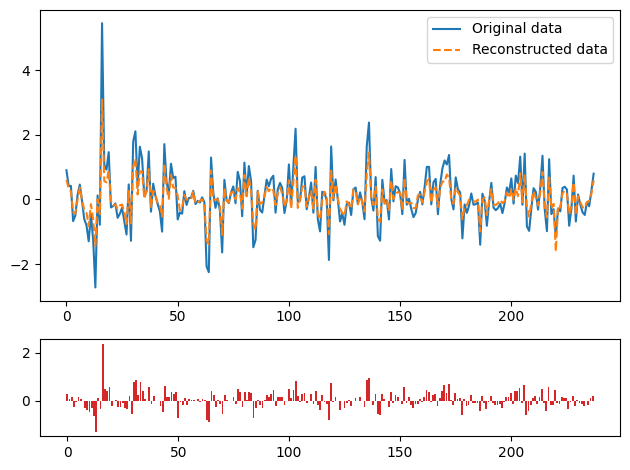

In [ ]:
# Crea una griglia di subplot con altezze specificate
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

# Traccia i dati originali e ricostruiti sul primo asse
ax1.plot(benchmark_30, label='Original data')
ax1.plot(result_30, label='Reconstructed data', linestyle = 'dashed')
ax1.legend()

# Calcola le differenze e traccia come un grafico a barre sul secondo asse
difference = benchmark_30 - result_30
ax2.bar(range(len(difference)), difference, color='tab:red')

# Mostra i grafici
plt.tight_layout()
plt.show()

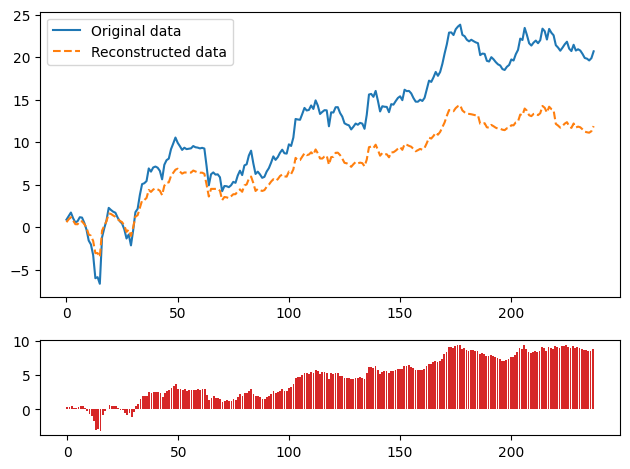

In [ ]:
# Crea una griglia di subplot con altezze specificate
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

# Traccia i dati originali e ricostruiti sul primo asse
ax1.plot(np.cumsum(benchmark_30), label='Original data')
ax1.plot(np.cumsum(result_30), label='Reconstructed data', linestyle = 'dashed')
ax1.legend()

# Calcola le differenze e traccia come un grafico a barre sul secondo asse
difference = np.cumsum(benchmark_30) - np.cumsum(result_30)
ax2.bar(range(len(difference)), difference, color='tab:red')

# Mostra i grafici
plt.tight_layout()
plt.show()


Also with 30 companies the graphs are similar to the previous ones.